<a href="https://colab.research.google.com/github/Yalnyra/Intel-Image-Dataset/blob/main/Vinokur_Model_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- У класі "street" і "glacier" багато чорно-білих фото, спробуємо grayscale зображень. Зображення вдень і вночі, в різні часи доби і освітлення. Різна розмірність фічей, як от куполів на фото, тому спробувати Resize.

Зображення чіткі, шумів не знайдено,

Припускаємо із візуалізованих даних, що всі належать до одного з 5 класів і відсутні wildcard класи.


TODO: Спробуємо знайти "щільність" кластерів даних об'єктів за допомогою UMAP, t-SNE чи PCA, іншої кластеризації для візуалізації відстаней, і позначити кольором до яких класів кожен датапоінт належить.

Dot-product зображень, t-test на корреляцію.
Корреляцію між зображеннями, scatter plot по PCA

Для обробки поки не виконуємо нормалізацію, треба невелику
- аугментація 20% зображень із одним з трьох варіантів
 - випадковим розширенням і поворотом для scale/affine invariance
 - Перетворенням на чорно-біле зображення
 0. Для великого зображення 150*150*3 збільшимо к-сть згорток з 4 до 6, з розмірами фіч мап
 0. Макс 4*4 пулінг
 1. Батч нормалізація

Що буде зроблено на даному етапі
<!-- - Зробимо взважування по частоті -->
-
<!-- - Спробуємо спочатку постійний learning rate, потім ще додамо з Lr scheduler. -->
- У Adam додамо параметр регуляризації


# Фінальний проєкт
## Класифікація зображень за допомогою PyTorch

**Мета роботи: Навчитись тренувати базову нейронну мережу для класифікації зображень.**

**Вимоги:**
1. Препроцессинг, train/pred, тест повністю на розмічених зображеннях.


 Аугментація: blur/grayscale/affine transform/noise

2. Архітектура:

 - Пару CNN шарів, 2-3 Linear

 - Max/median pooling, batch norm

3. Lr_rate finetuning,


In [ ]:
# @title Для colab потрібно опціональні частини torch
# %pip install torchvision

In [ ]:
# Image load

import os
from PIL import Image
from tempfile import TemporaryDirectory
import random
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm
# import torchvision
from torchvision.transforms import v2 as transforms
from torchvision import datasets, models
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.utils import make_grid
from torch.optim import Adam, lr_scheduler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, ConfusionMatrixDisplay
# import wandb


In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


Не працюємо з kaggle - встановіть [Dataset](https://www.kaggle.com/datasets/puneet6060/intel-image-classification/code) на гугл диск у папку URL перед початком роботи.

Логінитись у wandb не треба, просто закоментуйте
наступнф два рядки

In [ ]:
import wandb

In [ ]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

KeyboardInterrupt: 

In [ ]:

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
URL = "drive/MyDrive/Intel-Image-Classification"
# Альтернативний шлях, якщо працюєте з kaggle
# URL = "/kaggle/input/intel-image-classification"
folder = {"kaggle": 'seg_pred/seg_pred',
          'train': 'seg_train/seg_train',
          'test': 'seg_test/seg_test'
          }
BATCH_SIZE = 64
_NUM_WORKERS = os.cpu_count() // 2
_INPUT_SIZE = 150
SEED = 1234

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def to_device(X, y):
    return X.to(device), y.to(device, dtype=torch.int64)

In [ ]:
rng = np.random.default_rng(seed=SEED)

In [ ]:
# @title loading image from Intel Image folder
# @markdown # Запишемо всі лейбли і шляхи до файлів, -1 відповідає за непомічені дані
class ImageDataset(Dataset):
    def __init__(self, root_dir, train=True, transform=None, generator=rng):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.img_label_pairs = []
        self.classes = {}
        self.subdir = 'seg_train/seg_train' if train else 'seg_test/seg_test'

        # Collect all image paths and their corresponding labels
        subdir_path = os.path.join(root_dir, self.subdir)
        for class_name in os.listdir(subdir_path):
            class_path = os.path.join(subdir_path, class_name)
            if os.path.isdir(class_path):
                if class_name not in self.classes:
                    self.classes[class_name] = len(self.classes)
                for filename in os.listdir(class_path):
                    if filename.endswith('.jpg'):
                        self.img_label_pairs.append(
                            (os.path.join(class_path, filename),self.classes[class_name]))

        # # Collect images from seg_pred (unlabeled data)
        # unlabeled = os.path.join(root_dir, 'seg_pred/seg_pred')
        # for filename in os.listdir(unlabeled):
        #     if filename.endswith('.jpg'):
        #         self.img_label_pairs.append(
        #         (os.path.join(unlabeled, filename),-1)
        #         )

        rng.shuffle(self.img_label_pairs)



    @staticmethod
    def _to_tensor(image):
        return transforms.Compose([
            # transforms.ToImage(),
            # transforms.ToDtype(torch.float32, scale=True)
            transforms.ToTensor()
            ])(image)

    def __len__(self):
        return len(self.img_label_pairs)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path, label = self.img_label_pairs[idx]
        # image = ImageDataset._to_tensor(Image.open(img_path).convert('RGB'))
        image = Image.open(img_path)
        label = torch.tensor(label, dtype=torch.int)

        if self.transform:
            image = self.transform(image)

        return image, label

# Example usage:
# Define any transformations you want to apply to the images
transform = transforms.Compose([
    # transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Create the dataset
dataset = ImageDataset(root_dir=URL, transform=transform)

# Access an image tensor and its label
image_tensor, label = dataset[0]
print(image_tensor.shape, label)
classes = dataset.classes


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


torch.Size([3, 150, 150]) tensor(3, dtype=torch.int32)


Імплементація зверху дуже повільна

In [ ]:
URL

'drive/MyDrive/Intel-Image-Classification'

In [ ]:
"""
Args:
    root_dir (string): Directory with all the images.
    transform (callable, optional): Optional transform to be applied on a sample.
"""

train_dir = os.path.join(URL, folder['train'])
test_dir  = os.path.join(URL, folder['test'])

In [ ]:
class WrappedDataLoader:
    def __init__(self, loader, func):
        self.loader = loader
        self.func = func

    def __len__(self):
        return len(self.loader)

    def __iter__(self):
        for batch in iter(self.loader):
            yield self.func(*batch)

In [ ]:
affine_transforms = transforms.Compose([
    transforms.RandomAffine(degrees=15, translate=(0.15, 0.15), scale=(0.85, 1.15), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.RandomResizedCrop(size=(150, 150), scale=(0.15, 1), ratio=(1,1), antialias=True),
    transforms.RandomHorizontalFlip(p=0.),
])

augmentations = transforms.Compose([
    transforms.GaussianNoise(sigma=0.12),
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 1.0)),
])

In [ ]:
repeats = 50
features_size = BATCH_SIZE * repeats

In [ ]:
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((150,150), interpolation=transforms.InterpolationMode.BILINEAR, max_size=None, antialias=True),
    transforms.CenterCrop((150,150)),
    ])


In [ ]:
# features_mean = torch.zeros(1)
# features_squared_mean = torch.zeros(1)
# # Only use a few batches
# for item, label in data_train:
#     item = test_transforms(item)
#     features_mean += torch.mean(item)
#     features_squared_mean += torch.mean(item ** 2)
#     print(repeats)
#     repeats -= 1
#     if repeats <= 0:
#       break

# features_mean /= features_size
# features_squared_mean /= features_size

# features_std = torch.sqrt(features_squared_mean - features_mean ** 2)

In [ ]:
color_transforms = transforms.Compose([
    # transforms.Normalize(features_mean, features_std),
    transforms.ColorJitter(brightness=0.5, contrast=0.1, saturation=0.01),
])

In [ ]:
train_transforms = transforms.Compose([
    # transforms.ToDtype(torch.float32, scale=True),
    transforms.ToTensor(),
    transforms.Resize((150,150), interpolation=transforms.InterpolationMode.BILINEAR, max_size=None, antialias=True),
    transforms.CenterCrop((150,150)),
    transforms.RandomApply([
    transforms.RandomChoice([
        affine_transforms,
        augmentations,
        # color_transforms,
    ],)
  ], p=0.2),
  transforms.RandomGrayscale(p=0.2),
])

valid_transforms = transforms.Compose([
    # transforms.ToDtype(torch.float32, scale=True),
    transforms.ToTensor(),
    transforms.Resize((150,150), interpolation=transforms.InterpolationMode.BILINEAR, max_size=None, antialias=True),
    transforms.CenterCrop((150,150)),
    transforms.RandomApply([
    transforms.RandomChoice([
        affine_transforms,
    ])
  ], p=0.2),
])

In [ ]:
def loss(model, loss_func, X, y, optimizer=None):
    loss_ = loss_func(model(X), y)
    if optimizer is not None:
      loss_.backward()
      optimizer.step()
      optimizer.zero_grad()

    return loss_.item(), len(X)

In [ ]:
def validate(model, loss_func, X, y):
    output = model(X)
    loss_ = loss_func(output, y)
    pred = torch.argmax(output, dim=1)
    correct = pred == y.view(*pred.shape)

    return loss_.item(), torch.sum(correct).item(), len(X), pred, y.view(*pred.shape)

In [ ]:
def fit(epochs, model, loss_func, optimizer, train_loader, valid_loader, lr_scheduler=None, patience=10):
    graphic_losses = []

    wait = 0
    valid_loss_min = np.inf
    step = 0

    for epoch in tqdm(range(epochs)):
        step = epoch
        model.train()

        losses = []
        for X, y  in train_loader:
          # print(X.shape)
          losses.append(loss(model, loss_func, X, y, optimizer))

        losses, nums = zip(*losses)
        train_loss = sum(np.multiply(losses, nums)) / sum(nums)

        if lr_scheduler is not None:
            lr_scheduler.step()

        model.eval()

        with torch.no_grad():

            losses = []
            for X, y in valid_loader:
              losses.append(validate(model, loss_func, X, y))

            losses, corrects, nums, predicted, target = zip(*losses)
            target = torch.cat([*target], dim=0).cpu()
            predicted = torch.cat([*predicted],dim=0).cpu()
            valid_loss = sum(np.multiply(losses, nums)) / sum(nums)
            valid_accuracy = sum(corrects) / sum(nums) * 100
            # Changed from total class per-point  to average weighted
            valid_precision = precision_score(target, predicted, average='weighted')
            valid_recall = recall_score(target, predicted,  average='weighted')
            valid_f1 = f1_score(target, predicted,  average='weighted')


            print(f"\nepoch: {epoch+1:3}, loss: {train_loss:.5f}, valid loss: {valid_loss:.5f}, valid accuracy: {valid_accuracy:.3f}, valid f1: {valid_f1:.3f}%")

            graphic_losses.append((train_loss, valid_loss, valid_accuracy, valid_precision, valid_recall, valid_f1))
            # Save model if validation loss has decreased
            if valid_loss <= valid_loss_min:
                print(f"Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model...")
                torch.save(model.state_dict(), 'model.pt')
                valid_loss_min = valid_loss
                wait = 0
            # Early stopping
            else:
                wait += 1
                if wait >= patience:
                    print(f"Terminated Training for Early Stopping at Epoch {epoch+1}")
                    return graphic_losses, step

    return graphic_losses, step

### Тестування моделі

- На додачу до простого Accuracy, потрібно знайти
Precision
$TP \div (TP+FP)$

Recall
$TN \div (TN+FN)$

F1 $\frac{1}{\frac{1}{Precision}+\frac{1}{Recall}} $

Матрицю зкуйовдженості

In [ ]:
def evaluate(model, loss_func, loader):
    model.eval()

    with torch.no_grad():
        validated_batches = []

        for X, y in loader:
          validated_batches.append(validate(model, loss_func, X, y))

        losses, corrects, nums, predicted, target = zip(*validated_batches)
        target = torch.cat([*target], dim=0).cpu()
        predicted = torch.cat([*predicted],dim=0).cpu()
        cm = ConfusionMatrixDisplay.from_predictions(target, predicted)
        plt.show()
        test_loss = sum(np.multiply(losses, nums)) / sum(nums)
        test_accuracy = sum(corrects) / sum(nums) * 100
        test_precision = precision_score(target, predicted,  average='micro')
        test_recall = recall_score(target, predicted,  average='micro')
        test_f1 = f1_score(target, predicted,  average='micro')



    print(f"Test loss: {test_loss:.5f}\t",
          f"Test accuracy: {test_accuracy:.3f}%",
          f"Test precision: {test_precision:.3f}",
          f"Test recall: {test_recall:.3f}"
          f"Test f1: {test_f1:.3f}")
    return test_loss, test_accuracy, test_precision, test_recall, test_f1, cm

In [ ]:
from scipy.interpolate import make_interp_spline

In [ ]:
# # Створюємо координати X для детальної кривої навчання
# batches_per_epoch = len(train_loader)
# total_batches = batches_per_epoch * epochs
# batch_x = np.linspace(0, epochs, total_batches)

# # Створюємо координати X для середніх втрат за епохи
# epoch_x = np.array(range(1, epochs + 1)) - 0.5 # Зміщуємо на -0.5 для кращого візуального узгодження

# # Створюємо плавну криву для валідаційних втрат
# if len(val_losses) > 2:  # Потрібно щонайменше 3 точки для сплайна
#     x_smooth = np.linspace(epoch_x.min(), epoch_x.max(), 100)
#     spl = make_interp_spline(
#         epoch_x, val_losses, k=min(2, len(val_losses) - 1)
#     )  # k визначає порядок сплайна
#     val_losses_smooth = spl(x_smooth)
# else:
#     x_smooth = epoch_x
#     val_losses_smooth = val_losses

# # Палітра кольорів для більш професійного вигляду
# train_batch_color = "#8ECAE6"  # світло-блакитний
# train_epoch_color = "#0077B6"  # насичений синій
# val_color = "#FB8500"  # помаранчевий

# # Візуалізація втрат
# plt.figure(figsize=(12, 6))

# # Графік детальних втрат тренування
# plt.plot(
#     batch_x,
#     batch_train_losses,
#     train_batch_color,
#     alpha=0.3,
#     label="Втрати по батчах",
#     linewidth=1.5,
# )

# # Графік середніх втрат на тренуванні
# plt.plot(
#     epoch_x,
#     train_losses,
#     "o-",
#     color=train_epoch_color,
#     linewidth=2.5,
#     markersize=8,
#     label="Середні втрати на тренуванні",
# )

# # Графік валідаційних втрат (згладжені лінія + точки на одній кривій)
# plt.plot(
#     x_smooth,
#     val_losses_smooth,
#     color=val_color,
#     linewidth=2.5,
#     label="Втрати на валідації",
# )
# # Додаємо оригінальні точки на тій самій кривій
# plt.scatter(
#     epoch_x, val_losses, color=val_color, s=65, zorder=5, edgecolor="white", linewidth=1
# )

# plt.xlabel("Епохи", fontsize=14)
# plt.ylabel("Втрати", fontsize=14)
# plt.title("Криві навчання (детальна візуалізація)", fontsize=16)
# plt.grid(alpha=0.3)
# plt.legend(fontsize=12)
# plt.tight_layout()
# plt.show()

In [ ]:
def training_plots(losses_arr):
    plt.figure(figsize=(8,6))
    plt.plot([x[2] for x in losses_arr])
    plt.ylabel('Accuracy in %')
    plt.xlabel('Epochs')
    plt.xticks([x + 1 for x in range(len(losses_arr)) if x % 2 == 1])
    plt.show()

    plt.figure(figsize=(8,6))
    plt.plot([x[3] for x in losses_arr])
    plt.ylabel('Precision')
    plt.xlabel('Epochs')
    plt.xticks([x + 1 for x in range(len(losses_arr)) if x % 2 == 1])
    plt.show()

    plt.figure(figsize=(8,6))
    plt.plot([x[4] for x in losses_arr])
    plt.ylabel('Recall')
    plt.xlabel('Epochs')
    plt.xticks([x + 1 for x in range(len(losses_arr)) if x % 2 == 1])
    plt.show()

    plt.figure(figsize=(8,6))
    plt.plot([x[5] for x in losses_arr])
    plt.ylabel('F1')
    plt.xlabel('Epochs')
    plt.xticks([x + 1 for x in range(len(losses_arr)) if x % 2 == 1])
    plt.show()

    plt.figure(figsize=(8,6))
    plt.plot([x[0] for x in losses_arr], label='train loss')
    plt.plot([x[1] for x in losses_arr], label='validation loss')
    plt.legend(loc="upper right")
    plt.ylabel('Losses')
    plt.xlabel('Epochs')
    plt.xticks([x + 1 for x in range(len(losses_arr)) if x % 2 == 1])
    plt.show()

In [ ]:
model_path = lambda name: f"{URL}/{name}.pt"

In [ ]:
if not os.path.exists(model_path('')):
      os.makedirs(model_path(''))

In [ ]:
train_transforms

# valid_transforms

# test_transforms

Compose(
      ToTensor()
      Resize(size=[150, 150], interpolation=InterpolationMode.BILINEAR, antialias=True)
      CenterCrop(size=(150, 150))
      RandomApply(
        RandomChoice(
      transforms=[Compose(
            RandomAffine(degrees=[-15.0, 15.0], translate=(0.15, 0.15), scale=(0.85, 1.15), interpolation=InterpolationMode.BILINEAR, fill=0)
            RandomResizedCrop(size=(150, 150), scale=(0.15, 1), ratio=(1, 1), interpolation=InterpolationMode.BILINEAR, antialias=True)
            RandomHorizontalFlip(p=0.0)
      ), Compose(
            GaussianNoise(mean=0.0, sigma=0.12, clip=True)
            GaussianBlur(kernel_size=(3, 3), sigma=[0.1, 1.0])
      )], p=[0.5, 0.5]
    )
  )
      RandomGrayscale(p=0.2)
)

In [ ]:
def train(model, criterion, optimizer, n_epochs, batch_size, train_transforms, lr_scheduler=None, saving_model_path=None, wb = False):

    # data_train = ImageDataset(URL, True, train_transforms)

    # dataset_eval = ImageDataset(URL, True, valid_transforms)

    # data_test = ImageDataset(URL, test_transforms)

    data_train = datasets.ImageFolder(train_dir, train_transforms)
    data_test = datasets.ImageFolder(test_dir, test_transforms)
    print(data_train.transform)
    data_train, data_valid = random_split(data_train, lengths=[0.8, 0.2])


    loader_train = WrappedDataLoader(DataLoader(data_train, batch_size=batch_size, shuffle=True), to_device)
    loader_eval = WrappedDataLoader(DataLoader(data_valid, batch_size=batch_size, shuffle=False), to_device)
    loader_test = WrappedDataLoader(DataLoader(data_test, batch_size=batch_size, shuffle=False), to_device)

    print('\nFitting nn model')
    start_time = time.time()

    train_losses, final_step = fit(n_epochs, model, criterion, optimizer, loader_train, loader_eval, lr_scheduler)
    print(f'length array:', len(train_losses))
    print(f'Fit time: {time.time() - start_time} s')
    if wb:
        wandb.log({"train/duration": time.time() - start_time})
    check_point = torch.load('model.pt', map_location=device)
    model.load_state_dict(check_point)

    eval_losses = evaluate(model, criterion, loader_test)

    if saving_model_path is not None:
        print('Saving model')
        # create 'dynamic' dir, if it does not exist
        if not os.path.exists(model_path('')):
          os.makedirs(model_path(''))
        torch.save(model.state_dict(), model_path(saving_model_path))
        if wb:
            wandb.log_model(path=model_path(saving_model_path),name=saving_model_path)
            for i in range(final_step):
                train_loss, v_loss, v_acc, v_prec, v_recall, v_f1 = train_losses[i]
                wb_dict = {
                    "train/loss": train_loss,
                    "valid/loss": v_loss,
                    "valid/accuracy": v_acc,
                    "valid/precision": v_prec,
                    "valid/recall": v_recall,
                    "valid/f1": v_f1,
                           }
                wandb.log(wb_dict, step=i)
            test_loss, t_acc, t_prec, t_recall, t_f1, fig = eval_losses
            wandb.log({"test/loss": test_loss,
                    "test/accuracy": t_acc,
                    "test/precision": t_prec,
                    "test/recall": t_recall,
                    "test/f1": t_f1}, step=final_step+1)
            wandb.log({"fig":wandb.Image(fig.confusion_matrix)})

    training_plots(train_losses)

In [ ]:
class BasicModel(nn.Module):
    def __init__(self):
        super().__init__()
        # 32 * 3 -> 16 -> 16
        self.bn11 = nn.BatchNorm2d(3)
        self.conv11 = nn.Conv2d(3, 75, 3, padding="same") #3/16
        self.bn12 = nn.BatchNorm2d(75) # 16
        self.conv12 = nn.Conv2d(75, 75, 3, padding="same") #16/16
        self.bn21 = nn.BatchNorm2d(75) # 16
        self.conv21 = nn.Conv2d(75, 450, 3, padding="same") #16/32
        self.bn22 = nn.BatchNorm2d(150) # 32
        self.conv22 = nn.Conv2d(450, 450, 3, padding="same") #32/32 -> 150 * 37 * 37
        # self.bn31 = nn.BatchNorm2d(75) # 16
        self.conv31 = nn.Conv2d(450, 1350, 3, padding="same") #16/32 -> 450*9*9
        # self.bn32 = nn.BatchNorm2d(150) # 32
        self.conv32 = nn.Conv2d(1350, 1350, 3, padding="same") #32/32 -> 1350*2*2
        self.fc1 = nn.Linear(5400, 256) # 32 * 64
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, len(classes))

    def forward(self, x):
        x = F.relu(self.conv11(self.bn11(x)))
        x=  F.relu(self.conv12(self.bn12(x)))
        x = F.max_pool2d(x, 4)
        # print("\n", x.shape)
        x = F.relu(self.conv21(self.bn21(x)))
        x = F.relu(self.conv22(self.bn22(x)))
        x = F.max_pool2d(x, 4)
        # print("\n", x.shape)
        x = F.relu(self.conv31(self.bn31(x)))
        x = F.relu(self.conv32(self.bn32(x)))
        x = F.max_pool2d(x, 4)
        # print("\n", x.shape)
        x = x.view(-1, 5400)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # x = F.dropout(F.relu(self.fc2(x)), 0.2)
        x = self.fc3(x)
        return x

In [ ]:
# class_weights = torch.tensor(calculate_class_weights(y_train), dtype=torch.float, device=device)
n_epochs = 50
BATCH_SIZE = 32

In [ ]:
model = BasicModel().to(device)
# criterion = nn.CrossEntropyLoss(class_weights)
# criterion = nn.
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-3)
lr_sch = lr_scheduler.StepLR(optimizer, 30, 0.3)

In [ ]:
BATCH_SIZE = 16

Тренуємо на 75->450->1350 фіч мапах без
трансформацій grayscale, нормалізації чи збільшення розміру

In [ ]:
train(model, criterion, optimizer, n_epochs, BATCH_SIZE, train_transforms, lr_scheduler=lr_sch, saving_model_path='small_img_model', wb=False)

Compose(
      ToTensor()
      Resize(size=[150, 150], interpolation=InterpolationMode.BILINEAR, antialias=True)
      CenterCrop(size=(150, 150))
      RandomApply(
        RandomChoice(
      transforms=[Compose(
            RandomAffine(degrees=[-15.0, 15.0], translate=(0.15, 0.15), scale=(0.85, 1.15), interpolation=InterpolationMode.BILINEAR, fill=0)
            RandomResizedCrop(size=(150, 150), scale=(0.15, 1), ratio=(1, 1), interpolation=InterpolationMode.BILINEAR, antialias=True)
            RandomHorizontalFlip(p=0.0)
      ), Compose(
            GaussianNoise(mean=0.0, sigma=0.12, clip=True)
            GaussianBlur(kernel_size=(3, 3), sigma=[0.1, 1.0])
      )], p=[0.5, 0.5]
    )
  )
      RandomGrayscale(p=0.2)
)

Fitting nn model


  0%|          | 0/50 [00:00<?, ?it/s]


RuntimeError: shape '[-1, 1800]' is invalid for input of size 82944

In [ ]:
Fitting nn model
  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

epoch:   1, loss: 1.79933, valid loss: 1.79140, valid accuracy: 17.320, valid f1: 0.051%
Validation loss decreased (inf --> 1.791401). Saving model...
  2%|▏         | 1/50 [08:51<7:14:24, 531.93s/it]

  Перша Конволюція із 150 призводить до таких результатів

In [ ]:
model = BasicModel().to(device)
with wandb.init(
        settings=wandb.Settings(start_method="thread"),
        project="Kaggle-Intel-Image",
        name='small_img_model',
        group='CNN',
        config={"epochs":n_epochs, "batch": BATCH_SIZE, "transforms": train_transforms},
        sync_tensorboard=False,
        resume="allow",
    ):
        train(model, criterion, optimizer, n_epochs, BATCH_SIZE, train_transforms, lr_scheduler=lr_sch, saving_model_path='small_img_model', wb=True)

In [ ]:
classes

Можливо ColorJitter руйнує? Бо маленькі feature map навпаки робили тільки гірше, можливо варто зменшити розмір зображення

### Висновки по тренуванню
Поки що оверфітиться після 10 епох, 86% непоганий результат

З lr 1e-3 впадає у локальний мінімум, з точністю ~67%

У матриці плутанини найбільше помилок зустрічається в 3 конкретних класах з 10:

2: bird  3: cat 4: deer, меншою мірою 5: dog, тобто фото звірів найменше відрізняються між собою на 32*32 зображеннях.

1. ColorJitter і афінні трансформ, lr=0.003 без learning rate decay, з dropout

2. Colorjitter, з lr_scheduler, початковий 0.003
 За 31 епоху дійшло до 74%, далі пішло в плато

3. Випадковий поворот (advanced_transforms), lr=0.003

- Поступово збігається до 50/50, субоптимальний, не виправдовує робастність

4. train_transforms Без colorjitter, lr=0.001 дійшло до 70%, далі пішло в плато.

5. Color_jitter, з saturation gain убавленою з 0.2 до 0.05, lr=0.001
Після 50 епох дійшло до 77.5% на тестовій вибірці і не збиралось зупинятись


In [ ]:
# @title З меншим feature map модель, як вплине на продуктивність?

class FeatMapModel(nn.Module):
    def __init__(self):
        super().__init__()
        # 32 * 3 -> 16 -> 16
        self.bn11 = nn.BatchNorm2d(3)
        self.conv11 = nn.Conv2d(3, 16, 3, padding="same") #3/16
        self.bn12 = nn.BatchNorm2d(16) # 16
        self.conv12 = nn.Conv2d(16, 16, 3, padding="same") #16/16
        self.bn21 = nn.BatchNorm2d(16) # 16
        self.conv21 = nn.Conv2d(16, 32, 3, padding="same") #16/32
        self.bn22 = nn.BatchNorm2d(32) # 32
        self.conv22 = nn.Conv2d(32, 32, 3, padding="same") #32/32 -> 150 * 37 * 37
        # self.bn31 = nn.BatchNorm2d(75) # 16
        self.conv31 = nn.Conv2d(32, 64, 3, padding="same") #16/32 -> 450*9*9
        # self.bn32 = nn.BatchNorm2d(150) # 32
        self.conv32 = nn.Conv2d(64, 64, 3, padding="same") #32/32 -> 1350*2*2
        # self.fc1 = nn.Linear(256, 512) # 8192
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, len(classes))

    def forward(self, x):
        x = F.relu(self.conv11(self.bn11(x)))
        x=  F.relu(self.conv12(self.bn12(x)))
        x = F.max_pool2d(x, 4)
        # print("\n", x.shape)
        x = F.relu(self.conv21(self.bn21(x)))
        x = F.relu(self.conv22(self.bn22(x)))
        x = F.max_pool2d(x, 4)
        # print("\n", x.shape)
        x = F.relu(self.conv31(x))
        x = F.relu(self.conv32(x))
        x = F.max_pool2d(x, 4)
        # print("\n", x.shape)
        # print(x.shape)
        x = x.view(-1, 256)
        # print(x.shape)
        # x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # x = F.dropout(F.relu(self.fc2(x)), 0.2)
        x = self.fc3(x)
        return x

In [ ]:
feat_model = FeatMapModel().to(device)


In [ ]:
# with wandb.init(
#         settings=wandb.Settings(start_method="thread"),
#         project="Kaggle-Intel-Image",
#         name='dropout_tuned',
#         group='CNN',
#         config={"epochs":n_epochs, "batch": BATCH_SIZE, "transforms": train_transforms},
#         sync_tensorboard=False,
#         resume="allow",
#     ):
train(feat_model, criterion, optimizer, n_epochs, BATCH_SIZE, train_transforms, lr_scheduler=lr_sch, saving_model_path='feat_model', wb=False)

Compose(
      ToTensor()
      Resize(size=[150, 150], interpolation=InterpolationMode.BILINEAR, antialias=True)
      CenterCrop(size=(150, 150))
      RandomApply(
        RandomChoice(
      transforms=[Compose(
            RandomAffine(degrees=[-15.0, 15.0], translate=(0.15, 0.15), scale=(0.85, 1.15), interpolation=InterpolationMode.BILINEAR, fill=0)
            RandomResizedCrop(size=(150, 150), scale=(0.15, 1), ratio=(1, 1), interpolation=InterpolationMode.BILINEAR, antialias=True)
            RandomHorizontalFlip(p=0.0)
      ), Compose(
            GaussianNoise(mean=0.0, sigma=0.12, clip=True)
            GaussianBlur(kernel_size=(3, 3), sigma=[0.1, 1.0])
      )], p=[0.5, 0.5]
    )
  )
      RandomGrayscale(p=0.2)
)

Fitting nn model


  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  2%|▏         | 1/50 [01:33<1:16:43, 93.95s/it]


epoch:   1, loss: 1.78904, valid loss: 1.78911, valid accuracy: 15.538, valid f1: 0.064%
Validation loss decreased (inf --> 1.789114). Saving model...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  4%|▍         | 2/50 [03:02<1:12:33, 90.69s/it]


epoch:   2, loss: 1.78902, valid loss: 1.78906, valid accuracy: 16.073, valid f1: 0.076%
Validation loss decreased (1.789114 --> 1.789064). Saving model...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  6%|▌         | 3/50 [04:15<1:04:36, 82.48s/it]


epoch:   3, loss: 1.78907, valid loss: 1.78909, valid accuracy: 15.930, valid f1: 0.069%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  8%|▊         | 4/50 [05:27<1:00:13, 78.56s/it]


epoch:   4, loss: 1.78894, valid loss: 1.78904, valid accuracy: 15.966, valid f1: 0.069%
Validation loss decreased (1.789064 --> 1.789042). Saving model...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 10%|█         | 5/50 [06:38<56:45, 75.68s/it]  


epoch:   5, loss: 1.78899, valid loss: 1.78892, valid accuracy: 15.859, valid f1: 0.072%
Validation loss decreased (1.789042 --> 1.788924). Saving model...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 12%|█▏        | 6/50 [07:49<54:20, 74.10s/it]


epoch:   6, loss: 1.78890, valid loss: 1.78881, valid accuracy: 16.251, valid f1: 0.073%
Validation loss decreased (1.788924 --> 1.788812). Saving model...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 14%|█▍        | 7/50 [09:00<52:23, 73.11s/it]


epoch:   7, loss: 1.78884, valid loss: 1.78919, valid accuracy: 15.645, valid f1: 0.068%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 16%|█▌        | 8/50 [10:10<50:32, 72.20s/it]


epoch:   8, loss: 1.78905, valid loss: 1.78906, valid accuracy: 16.001, valid f1: 0.071%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 18%|█▊        | 9/50 [11:22<49:15, 72.10s/it]


epoch:   9, loss: 1.78892, valid loss: 1.78885, valid accuracy: 15.788, valid f1: 0.068%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 20%|██        | 10/50 [12:33<47:52, 71.80s/it]


epoch:  10, loss: 1.78898, valid loss: 1.78890, valid accuracy: 15.823, valid f1: 0.068%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 22%|██▏       | 11/50 [13:44<46:28, 71.49s/it]


epoch:  11, loss: 1.78893, valid loss: 1.78904, valid accuracy: 15.895, valid f1: 0.073%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 24%|██▍       | 12/50 [14:55<45:14, 71.44s/it]


epoch:  12, loss: 1.78901, valid loss: 1.78908, valid accuracy: 15.966, valid f1: 0.072%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 26%|██▌       | 13/50 [16:07<44:09, 71.60s/it]


epoch:  13, loss: 1.78895, valid loss: 1.78908, valid accuracy: 15.859, valid f1: 0.068%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 28%|██▊       | 14/50 [17:19<43:03, 71.75s/it]


epoch:  14, loss: 1.78910, valid loss: 1.78889, valid accuracy: 15.752, valid f1: 0.070%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 30%|███       | 15/50 [18:33<42:10, 72.29s/it]


epoch:  15, loss: 1.78904, valid loss: 1.78898, valid accuracy: 15.930, valid f1: 0.074%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 30%|███       | 15/50 [19:43<46:01, 78.91s/it]



epoch:  16, loss: 1.78898, valid loss: 1.78889, valid accuracy: 15.681, valid f1: 0.070%
Terminated Training for Early Stopping at Epoch 16
length array: 16
Fit time: 1183.69224691391 s


KeyboardInterrupt: 

- Зменшення feature map з 75 до 16 не лише зменшило продуктивність вдвічі, а і зробила будь-які паттерни створені CNN занадто малими, щоб бути корисними для моделі

- Validation accuracy нижчий за Test, що може свідчити про певну користь від аугментацій, коли модель не страждає від ускладнень зображення, пов'язаних з ними.



In [ ]:
class BetterModel(nn.Module):
    def __init__(self):
        super().__init__()
        # 32 * 3 -> 16 -> 16
        self.bn11 = nn.BatchNorm2d(3)
        self.conv11 = nn.Conv2d(3, 75, 3, padding="same") #3/16
        self.bn12 = nn.BatchNorm2d(75) # 16
        self.conv12 = nn.Conv2d(75, 75, 3, padding="same") #16/16
        self.bn21 = nn.BatchNorm2d(75) # 16
        self.conv21 = nn.Conv2d(75, 450, 3, padding="same") #16/32
        self.bn22 = nn.BatchNorm2d(450) # 32
        self.conv22 = nn.Conv2d(450, 450, 3, padding="same") #32/32 -> 150 * 37 * 37
        # self.bn31 = nn.BatchNorm2d(75) # 16
        self.conv31 = nn.Conv2d(450, 1350, 3, padding="same") #16/32 -> 450*9*9
        # self.bn32 = nn.BatchNorm2d(150) # 32
        self.conv32 = nn.Conv2d(1350, 1350, 3, padding="same") #32/32 -> 1350*2*2
        self.fc1 = nn.Linear(5400, 512) # 32 * 64
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, len(classes))

    def forward(self, x):
        x = F.relu(self.conv11(self.bn11(x)))
        x=  F.relu(self.conv12(self.bn12(x)))
        x = F.max_pool2d(x, 4)
        # print("\n", x.shape)
        x = F.relu(self.conv21(self.bn21(x)))
        x = F.relu(self.conv22(self.bn22(x)))
        x = F.max_pool2d(x, 4)
        # print("\n", x.shape)
        x = F.relu(self.conv31(x))
        x = F.relu(self.conv32(x))
        x = F.max_pool2d(x, 4)
        # print("\n", x.shape)
        x = x.view(-1, 5400)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # x = F.dropout(F.relu(self.fc2(x)), 0.2)
        x = self.fc3(x)
        return x

17% accuracy, 0.065% f1 після 5 епох - Не будемо далі тренувати

In [ ]:
n_epochs = 10

In [ ]:
device = torch.device('cuda')

In [ ]:
model = BetterModel().to(device)

## Завантажуємо претреновану модель на 86% accuracy

In [ ]:
check_point = torch.load(model_path('max_model'), map_location=device)
model.load_state_dict(check_point)

<All keys matched successfully>

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: gpjedi (paradoxv15) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
n_epochs=200

Compose(
      ToTensor()
      Resize(size=[150, 150], interpolation=InterpolationMode.BILINEAR, antialias=True)
      CenterCrop(size=(150, 150))
      RandomApply(
        RandomChoice(
      transforms=[Compose(
            RandomAffine(degrees=[-15.0, 15.0], translate=(0.15, 0.15), scale=(0.85, 1.15), interpolation=InterpolationMode.BILINEAR, fill=0)
            RandomResizedCrop(size=(150, 150), scale=(0.15, 1), ratio=(1, 1), interpolation=InterpolationMode.BILINEAR, antialias=True)
            RandomHorizontalFlip(p=0.0)
      ), Compose(
            GaussianNoise(mean=0.0, sigma=0.12, clip=True)
            GaussianBlur(kernel_size=(3, 3), sigma=[0.1, 1.0])
      )], p=[0.5, 0.5]
    )
  )
      RandomGrayscale(p=0.2)
)

Fitting nn model


  0%|          | 0/200 [00:00<?, ?it/s]


epoch:   1, loss: 0.43383, valid loss: 0.42023, valid accuracy: 85.103, valid f1: 0.851%
Validation loss decreased (inf --> 0.420230). Saving model...


  0%|          | 1/200 [02:49<9:22:55, 169.73s/it]


epoch:   2, loss: 0.43925, valid loss: 0.40540, valid accuracy: 85.780, valid f1: 0.857%
Validation loss decreased (0.420230 --> 0.405401). Saving model...


  2%|▏         | 3/200 [07:51<8:29:08, 155.07s/it]


epoch:   3, loss: 0.43070, valid loss: 0.42495, valid accuracy: 84.640, valid f1: 0.846%


  2%|▏         | 4/200 [10:21<8:20:56, 153.35s/it]


epoch:   4, loss: 0.43724, valid loss: 0.41642, valid accuracy: 84.248, valid f1: 0.842%


  2%|▎         | 5/200 [12:52<8:15:20, 152.41s/it]


epoch:   5, loss: 0.43497, valid loss: 0.42979, valid accuracy: 84.284, valid f1: 0.842%


  3%|▎         | 6/200 [15:22<8:09:43, 151.46s/it]


epoch:   6, loss: 0.43656, valid loss: 0.43345, valid accuracy: 84.248, valid f1: 0.842%


  4%|▎         | 7/200 [17:52<8:06:07, 151.13s/it]


epoch:   7, loss: 0.43617, valid loss: 0.43395, valid accuracy: 84.569, valid f1: 0.845%


  4%|▍         | 8/200 [20:22<8:02:22, 150.74s/it]


epoch:   8, loss: 0.43892, valid loss: 0.42601, valid accuracy: 84.818, valid f1: 0.848%


  4%|▍         | 9/200 [22:52<7:59:07, 150.51s/it]


epoch:   9, loss: 0.43061, valid loss: 0.43546, valid accuracy: 84.498, valid f1: 0.844%

epoch:  10, loss: 0.43054, valid loss: 0.40457, valid accuracy: 85.032, valid f1: 0.850%
Validation loss decreased (0.405401 --> 0.404575). Saving model...


  6%|▌         | 11/200 [27:53<7:53:36, 150.35s/it]


epoch:  11, loss: 0.44164, valid loss: 0.42234, valid accuracy: 84.925, valid f1: 0.849%


  6%|▌         | 12/200 [30:22<7:49:58, 149.99s/it]


epoch:  12, loss: 0.43153, valid loss: 0.42182, valid accuracy: 85.103, valid f1: 0.850%


  6%|▋         | 13/200 [32:51<7:46:54, 149.81s/it]


epoch:  13, loss: 0.43489, valid loss: 0.42002, valid accuracy: 84.604, valid f1: 0.845%


  7%|▋         | 14/200 [35:21<7:44:04, 149.70s/it]


epoch:  14, loss: 0.43712, valid loss: 0.42519, valid accuracy: 84.498, valid f1: 0.844%


  8%|▊         | 15/200 [37:50<7:41:44, 149.75s/it]


epoch:  15, loss: 0.43494, valid loss: 0.40957, valid accuracy: 85.531, valid f1: 0.855%


  8%|▊         | 16/200 [40:21<7:39:53, 149.96s/it]


epoch:  16, loss: 0.43278, valid loss: 0.42302, valid accuracy: 84.498, valid f1: 0.845%


  8%|▊         | 17/200 [42:51<7:37:35, 150.03s/it]


epoch:  17, loss: 0.44297, valid loss: 0.42209, valid accuracy: 84.105, valid f1: 0.840%


  9%|▉         | 18/200 [45:20<7:34:29, 149.83s/it]


epoch:  18, loss: 0.42940, valid loss: 0.41360, valid accuracy: 85.210, valid f1: 0.851%


 10%|▉         | 19/200 [47:50<7:31:21, 149.62s/it]


epoch:  19, loss: 0.44091, valid loss: 0.42163, valid accuracy: 84.640, valid f1: 0.846%


 10%|▉         | 19/200 [50:19<7:59:24, 158.92s/it]


epoch:  20, loss: 0.43234, valid loss: 0.40828, valid accuracy: 85.175, valid f1: 0.851%
Terminated Training for Early Stopping at Epoch 20
length array: 20
Fit time: 3019.4437534809113 s


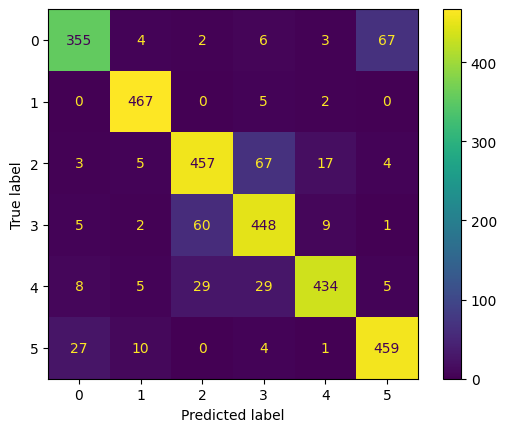

Test loss: 0.37600	 Test accuracy: 87.333% Test precision: 0.873 Test recall: 0.873Test f1: 0.873
Saving model


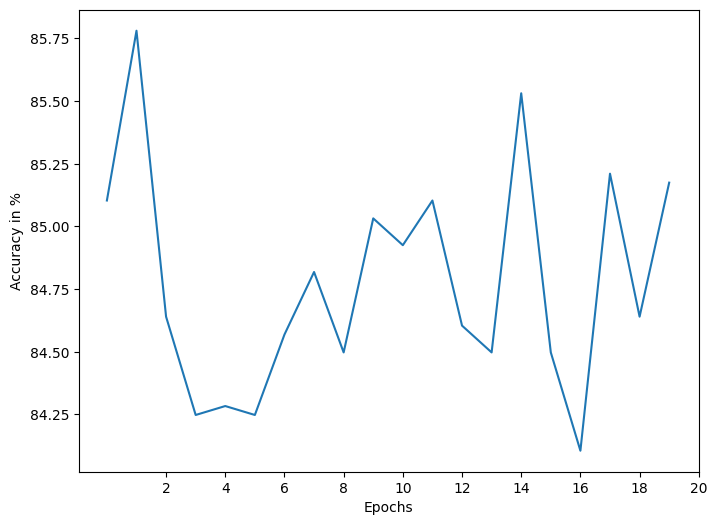

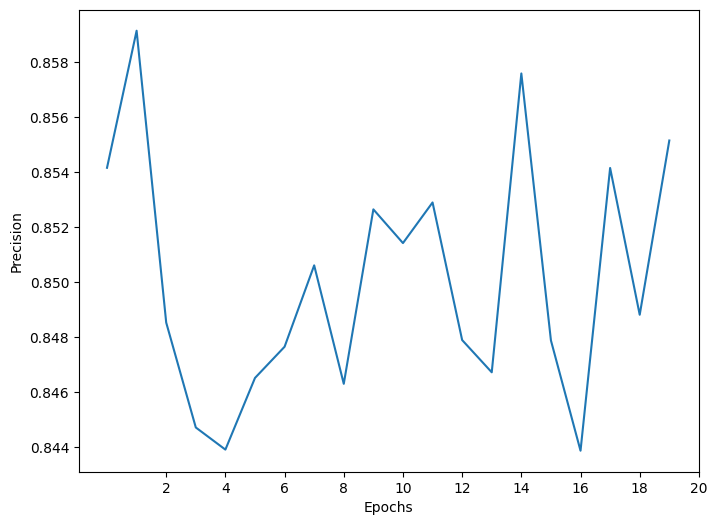

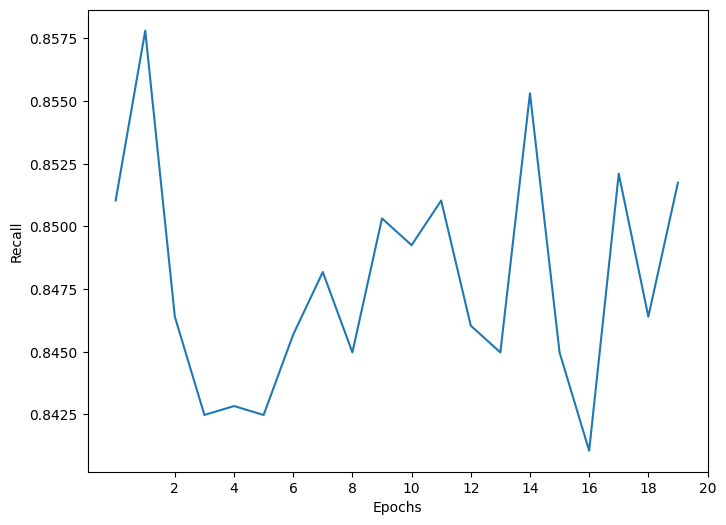

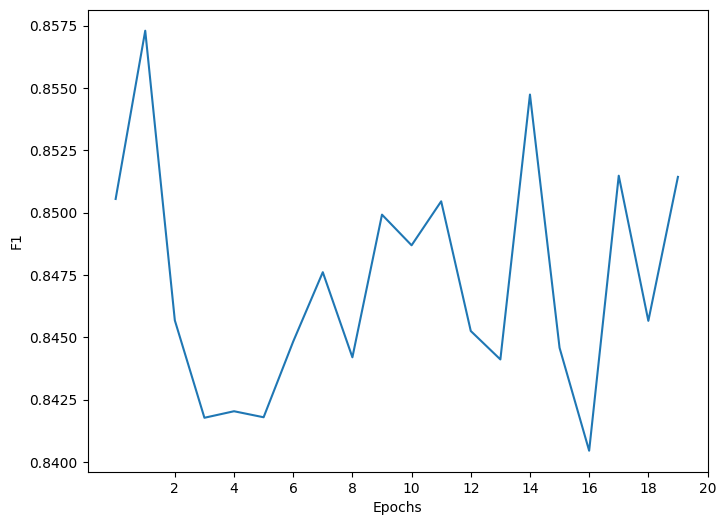

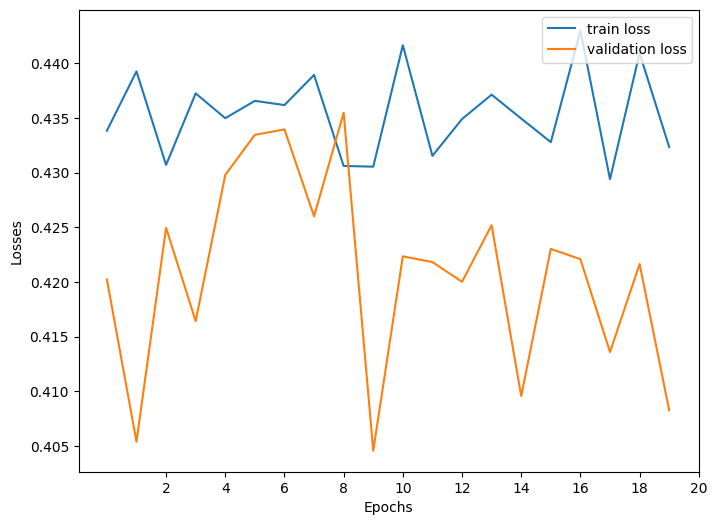

In [ ]:

with wandb.init(
          settings=wandb.Settings(start_method="thread"),
          project="Kaggle-Intel-Image",
          name='max_model_mk2',
          group='CNN',
          config={"epochs":n_epochs, "batch": BATCH_SIZE, "transforms": train_transforms},
          sync_tensorboard=False,
          resume="allow",
      ):
  train(model, criterion, optimizer, n_epochs, BATCH_SIZE, train_transforms, lr_scheduler=lr_sch, saving_model_path='max_model_mk2', wb=True)

# Результати за посиланням на [wandb](https://wandb.ai/paradoxv15/Kaggle-Intel-Image/reports/Model-tuning-for-Intel-Image-classifier--VmlldzoxMTgxOTgwMA)



In [ ]:
def validate_examples(model, loss_func, X, y):
    output = model(X)
    pred = torch.argmax(output, dim=1)
    correct = pred == y.view(*pred.shape)

    return X, pred, y.view(*pred.shape)

In [ ]:
def draw_predicted_examples(image_array, grid_x, grid_y, title):
    fig = plt.figure(figsize=(grid_x,grid_y))
    fig.suptitle(title, fontsize=20)

    for i in range(1,grid_y*grid_x+1):
        index = random.randint(0, len(image_array)-1)
        image = image_array[index]
        plt.axis('off')
        plt.subplot(grid_y,grid_x,i)
        plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))

In [ ]:
# Функція для денормалізації зображення
def denormalize_image(tensor, mean=0.5, std=0.5):
    # tensor має форму (channels, height, width); повертає зображення у форматі HxWxC
    img = tensor.cpu().numpy().transpose((1, 2, 0))
    img = std * img + mean
    return np.clip(img, 0, 1)


# Функція для відображення зображень з прогнозами (оновлено)
def show_predictions(model, dataloader, class_names, device, num_images=8):
    """
    Відображає приклади зображень з прогнозами моделі.
    """
    model.eval()
    images_so_far = 0
    plt.figure(figsize=(15, 8))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            preds = preds.cpu()
            labels = labels.cpu()
            for j in range(inputs.size(0)):
                true_label = labels[j].item()
                pred_label = preds[j].item()
                if images_so_far >= num_images:
                    return
                images_so_far += 1
                ax = plt.subplot(2, num_images // 2, images_so_far)
                ax.axis("off")
                status = "✓" if preds[j] == labels[j] else "✗"
                ax.set_title(
                    f"{status} Predicted: {class_names[pred_label]}\nTarget: {class_names[true_label]}",
                    color="green" if true_label == pred_label else "red",
                    fontsize=10,
                )
                # Використовуємо утиліту для денормалізації
                img = denormalize_image(inputs[j])
                plt.imshow(img)
    plt.tight_layout()
    plt.show()


# Функція для відображення лише помилкових прогнозів (оновлено)
def show_misclassifications(model, dataloader, class_names, device, max_per_class=5):
    """
    Відображає приклади помилково класифікованих зображень для кожного класу.
    """
    model.eval()
    misclassified = {i: [] for i in range(len(class_names))}

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size(0)):
                true_label = labels[j].item()
                pred_label = preds[j].item()
                if (
                    true_label != pred_label
                    and len(misclassified[true_label]) < max_per_class
                ):
                    img = denormalize_image(inputs[j])
                    misclassified[true_label].append((img, pred_label))

    for class_idx, examples in misclassified.items():
        if not examples:
            continue
        plt.figure(figsize=(15, 3))
        plt.suptitle(
            f"Misclassified as '{class_names[class_idx]}'",
            fontsize=14,
        )
        for i, (img, pred_label) in enumerate(examples):
            plt.subplot(1, len(examples), i + 1)
            plt.imshow(img)
            plt.title(
                f"Target: {class_names[class_idx]}\Predicted: {class_names[pred_label]}",
                color="red",
            )
            plt.axis("off")
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()


In [ ]:
# data_train = ImageDataset(URL, True, train_transforms)
# print(data_train.transform)
# # dataset_eval = ImageDataset(URL, True, valid_transforms)

# data_test = ImageDataset(URL, test_transforms)

data_train = datasets.ImageFolder(train_dir, train_transforms)
data_test = datasets.ImageFolder(test_dir, test_transforms)

data_train, data_valid = random_split(data_train, lengths=[0.8, 0.2])

loader_train = WrappedDataLoader(DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True), to_device)
loader_eval = WrappedDataLoader(DataLoader(data_valid, batch_size=BATCH_SIZE, shuffle=False), to_device)
loader_test = WrappedDataLoader(DataLoader(data_test, batch_size=BATCH_SIZE, shuffle=False), to_device)

In [ ]:
device = torch.device('cuda')

In [ ]:
classes = data_test.classes

In [ ]:
classes

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


Приклади помилкових класифікацій CNN моделі:


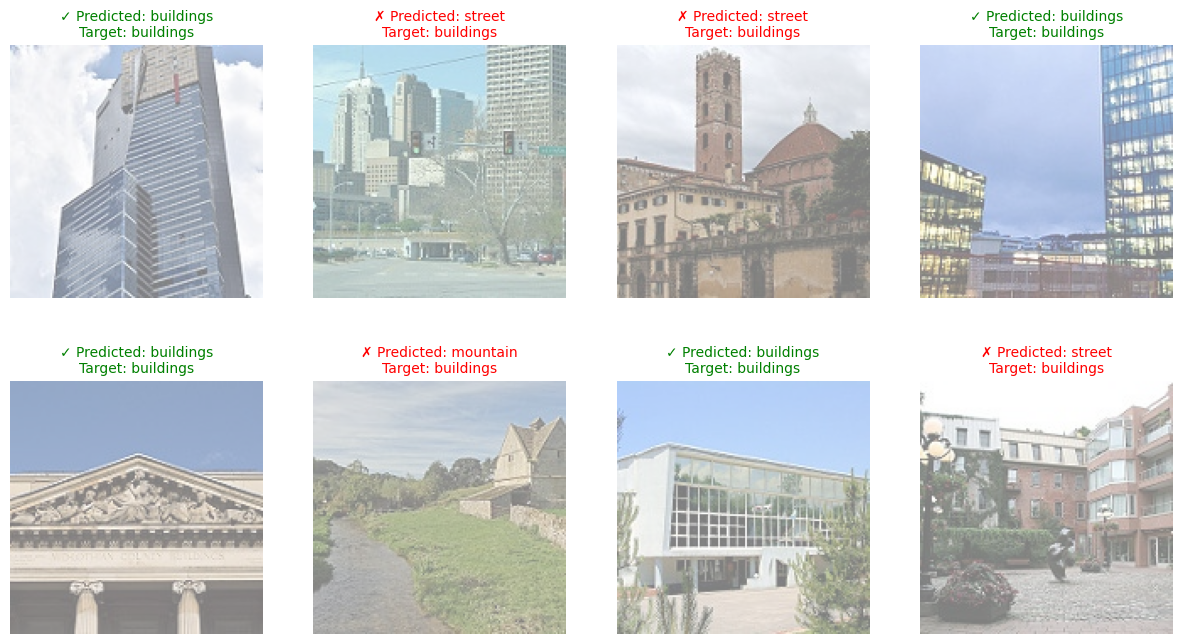

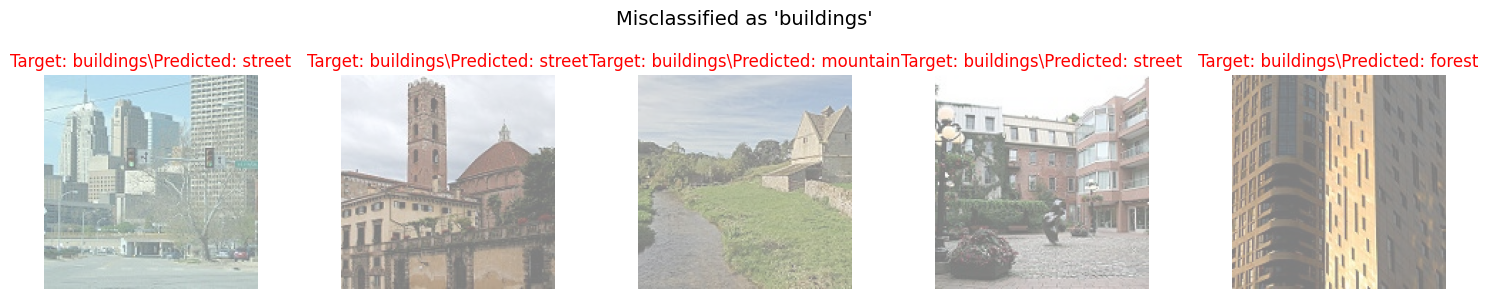

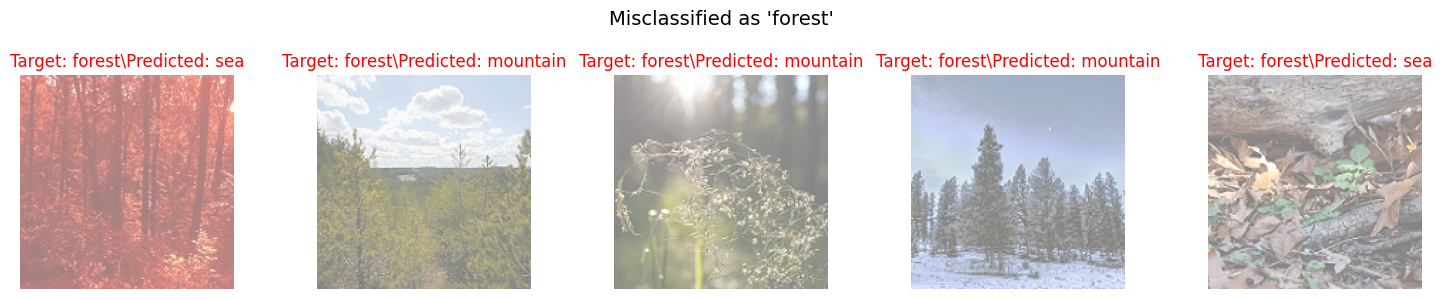

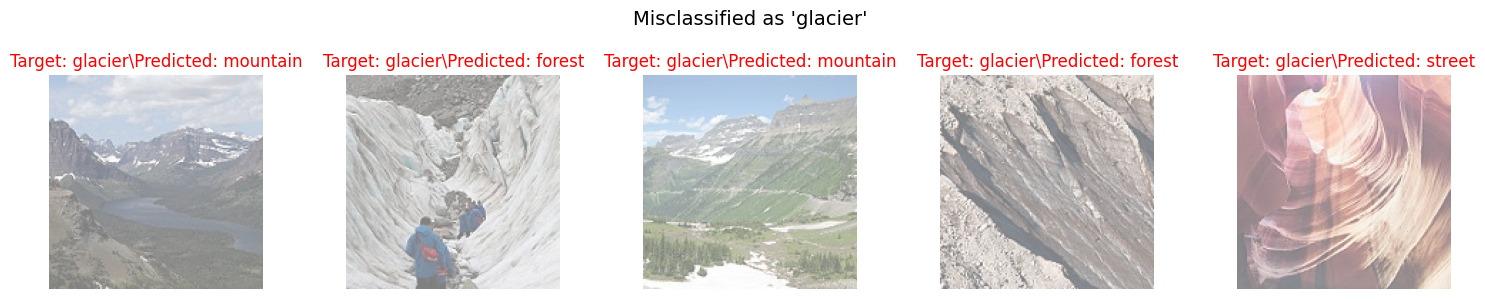

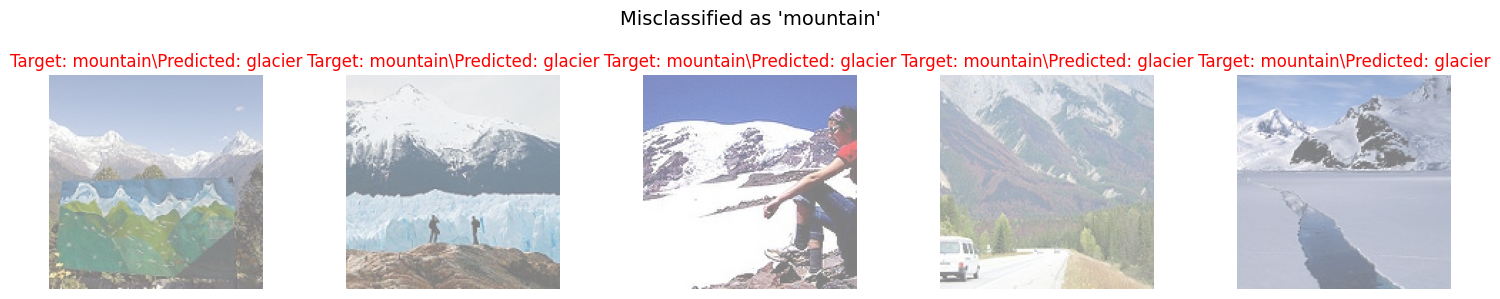

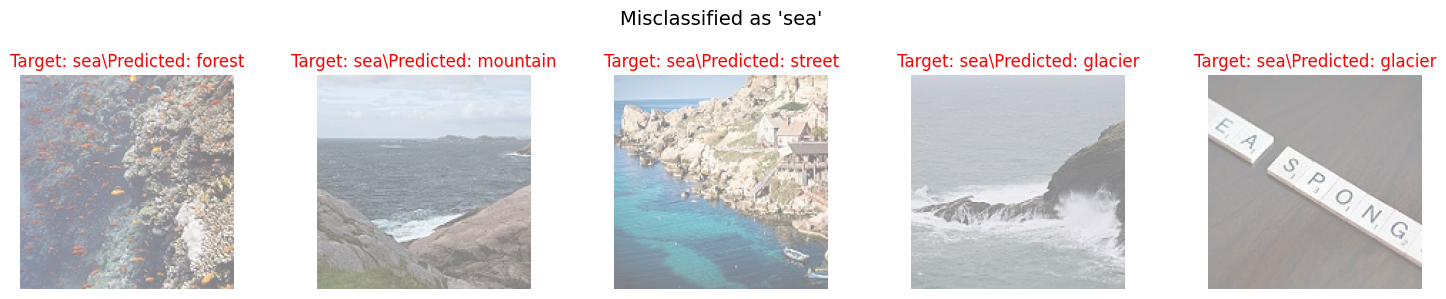

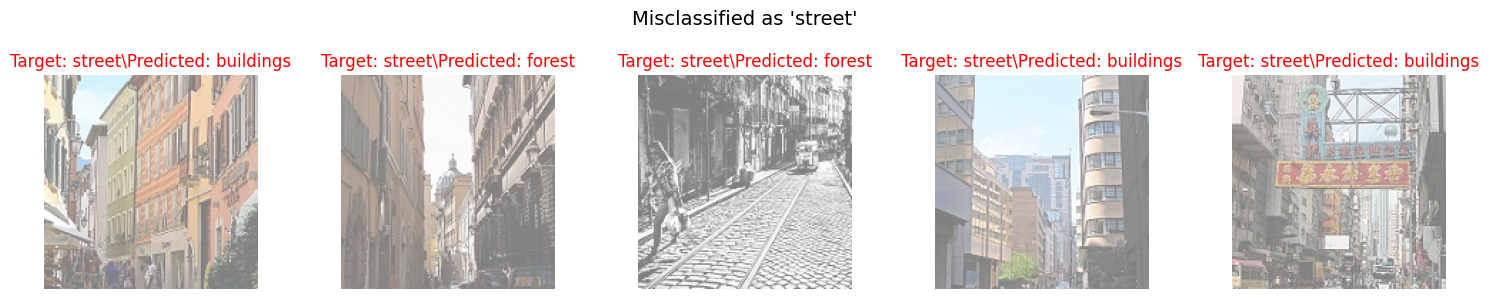

In [ ]:
# Показ прикладів прогнозів на валідаційному наборі
show_predictions(model, loader_test, classes, device)

# Показ прикладів ПОМИЛКОВИХ прогнозів для кожного класу
print("\nПриклади помилкових класифікацій CNN моделі:")
show_misclassifications(model, loader_test, classes, device)